<a href="https://colab.research.google.com/github/DaniAffCH/BeSTreet/blob/master/StreetTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import pandas as pd
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import OneHotEncoder
import time 
import datetime
import re
import urllib
import seaborn as sns


**Preprocessing**

In [64]:
def OneHotToDf(df, field):
  onehot_encoder = OneHotEncoder(sparse=False)
  arr = np.array(df[field])
  arrReshaped = arr.reshape(len(arr), 1)
  field_OH = onehot_encoder.fit_transform(arrReshaped)

  new_columns=list()
  for col, values in zip(df[field], onehot_encoder.categories_):
    new_columns.extend([field + '_' + str(value) for value in values])

  new_df= pd.concat([df, pd.DataFrame(field_OH, columns=new_columns)], axis='columns')
  del new_df[field]

  return new_df

def fromDataToGoniometric(date):
  minutiSettimana = 7*24*60
  data = re.search("(\d{2})/(\d{2})/(\d{4}) (\d{2}):(\d{2})", date)
  unix_timestamp = datetime.datetime(int(data.group(3)),int(data.group(2)),int(data.group(1)),int(data.group(4)),int(data.group(5))).timestamp()
  myTimestamp = unix_timestamp - (24 * 4 * 60 * 60)
  myTimestamp /= 60
  return [np.sin( 2 * np.pi * myTimestamp / minutiSettimana ), np.cos( 2 * np.pi * myTimestamp / minutiSettimana )]

def spazio():
  print("\n======================================================================\n")

Suddivisione strade:


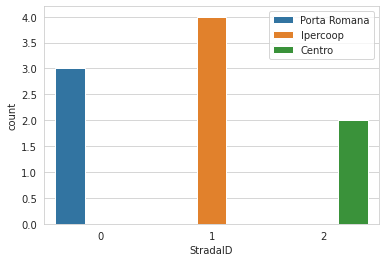



   Tempo  StradaID_0  StradaID_1  StradaID_2  sin_periodo  cos_periodo
0    609         1.0         0.0         0.0    -0.276836    -0.960917
1    412         0.0         1.0         0.0    -0.483719    -0.875223
2    471         0.0         1.0         0.0    -0.167506     0.985871
3    600         0.0         0.0         1.0     0.578671    -0.815561
4    437         0.0         1.0         0.0     0.399892    -0.916562


            Tempo  StradaID_0  StradaID_1  StradaID_2  sin_periodo  cos_periodo
count    9.000000    9.000000    9.000000    9.000000     9.000000     9.000000
mean   458.777778    0.333333    0.444444    0.222222     0.072798    -0.236197
std     92.235809    0.500000    0.527046    0.440959     0.548474     0.869167
min    352.000000    0.000000    0.000000    0.000000    -0.745642    -0.960917
25%    412.000000    0.000000    0.000000    0.000000    -0.276836    -0.916562
50%    437.000000    0.000000    0.000000    0.000000     0.009350    -0.815561
75%    471

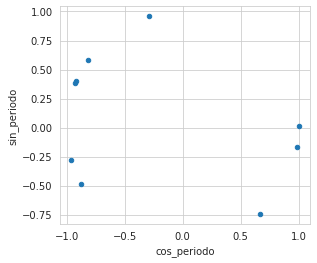

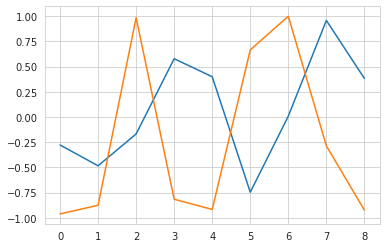

In [65]:
df = pd.read_csv("http://hoffnung.altervista.org/streetData.csv")
print("Suddivisione strade:")
sns.set_style('whitegrid')
sns.countplot(x = 'StradaID',hue="StradaID", data=df)
plt.legend(['Porta Romana', 'Ipercoop', 'Centro'])
plt.show()

spazio()

df = OneHotToDf(df, "StradaID")

# Encoding tempo come combinazione di seno/coseno (periodicità)

newCol = list()

for row in df["Data"]:
  newCol.append(fromDataToGoniometric(row))

df= pd.concat([df, pd.DataFrame(newCol, columns=["sin_periodo", "cos_periodo"])], axis='columns')
del df["Data"]

print(df.head())
spazio()
print(df.describe())
spazio()
print("Distribuzione periodo:")
df.plot.scatter('cos_periodo','sin_periodo').set_aspect('equal');
plt.show()

df.sin_periodo.plot()
df.cos_periodo.plot()

feature = ["StradaID_0", "StradaID_1", "StradaID_2", "sin_periodo", "cos_periodo"]
label = "Tempo"

**Modello**

In [66]:
def buildModel(my_learning_rate):
  model = keras.models.Sequential()
  layer = keras.layers.Dense(units=1)
  model.add(layer)
  model.compile(optimizer=keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[keras.metrics.RootMeanSquaredError()])
  return model

def fitModel(model, df, feature, label, batch_size, epochs):
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs)

  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  epochs = history.epoch
  
  hist = pd.DataFrame(history.history)
 
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

lr = 1
batch = 1
epochs = 150
model = buildModel(lr)
# Side effect su model??
tr_weight, tr_bias, epochs, rmse = fitModel(model, df, feature, label, batch, epochs)

Epoch 1/150

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 0s 1ms/step - loss: 206866.1875 - root_mean_squared_error: 454.8254
Epoch 2/150
9/9 [==============================] - 0s 1ms/step - loss: 188956.4375 - root_mean_squared_error: 434.6912
Epoch 3/150
9/9 [==============================] - 0s 1ms/step - loss: 175900.8125 - root_mean_squared_error: 419.4053
Epoch 4/150
9/9 [==============================] - 0s 1ms/step - loss: 164387.2344 - root_mean_squared_error: 405.4470
Epoch 5/150
9/9 [===============

**Errore e predict**

In [67]:
def plot_the_loss_curve(epochs, rmse):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()  


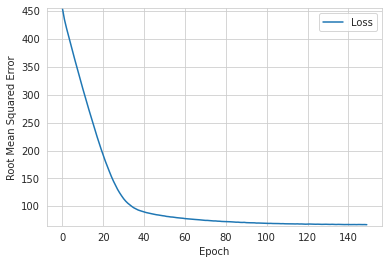

Pesi stimati: [[119.00997 ]
 [104.113106]
 [267.21323 ]
 [-89.62496 ]
 [-37.44542 ]]
Bias stimato:[310.79608]


In [68]:
plot_the_loss_curve(epochs, rmse)
print("Pesi stimati: {}\nBias stimato:{}".format(tr_weight, tr_bias))

Data: 05/09/2020 01:30
DATA PER IL PREDICT: 
[1, 0, 0, -0.9858710185183246, -0.16750622330421414]


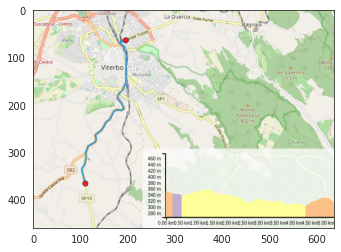

Verità-Porta Romana-Cassia, tempo stimato: 08:44

DATA PER IL PREDICT: 
[0, 1, 0, -0.9858710185183246, -0.16750622330421414]


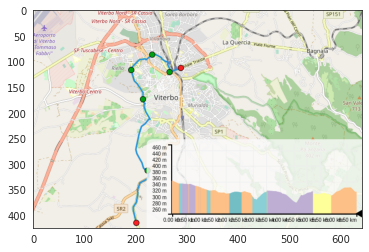

Ipercoop-Ponte Sodo, tempo stimato: 08:29

DATA PER IL PREDICT: 
[0, 0, 1, -0.9858710185183246, -0.16750622330421414]


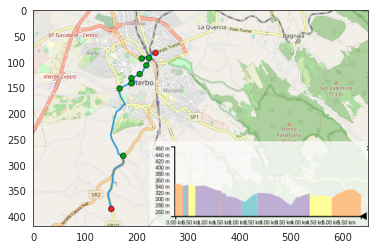

Centro-Ponte Sodo, tempo stimato: 11:12

Strada migliore: Ipercoop-Ponte Sodo


In [69]:
street = {
    0:"Verità-Porta Romana-Cassia",
    1:"Ipercoop-Ponte Sodo",
    2:"Centro-Ponte Sodo"
}

sns.set_style('white')

streetImg=["http://hoffnung.altervista.org/cassia.png","http://hoffnung.altervista.org/iper.png","http://hoffnung.altervista.org/centro.png"]

date = str()
flag = True

while(flag):
  date = input("Data: ")
  if(re.search("(\d{2})/(\d{2})/(\d{4}) (\d{2}):(\d{2})", date) == None):
    print("Formato data errato [gg/mm/aaaa hh:mm]")
  else:
    flag = False

out = dict()

for c in range(3):
  data = [[0, 0, 0]+fromDataToGoniometric(date)]
  data[0][c] = 1
  print("DATA PER IL PREDICT: ")
  predict = model.predict(data)[0][0]
  predictFormatted = str(datetime.timedelta(seconds=int(predict)))[-5:]
  print(data[0])

  img = mpimg.imread(urllib.request.urlopen(streetImg[c]))
  imgplot = plt.imshow(img)
  plt.show()

  print(street[c]+", tempo stimato: "+predictFormatted+"\n")
  out[predict] = street[c]

keyOfBest = sorted(list(out.keys()))[0]
print("Strada migliore: {}".format(out[keyOfBest]))